# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band6.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.968398 -0.852485 -0.955303 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.968398 -0.852485 -0.955303 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.968398 -0.852485 -0.955303 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.968398 -0.852485 -0.955303 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.968398 -0.852485 -0.955303 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0  -1.0 -0.837372   
      201547 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0  -1.0 -0.837372   
      201548 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0  -1.0 -0.837372   
      201549 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0  -1.0 -0.837372   
      201550 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0  -1.0 -0.837372   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.928059  -1.0 -0.861740  
      201547  -1.0 -0.928059  -1.0 -0.854589  
      201548  -1.0 -0.928059  -1.0 -0.856973  
      201549  -1.0 -0.928059  -1.0 -0.856973  
      201550  -1.0 -0.928059  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.000000 -0.968398 -0.852485 -0.955303 -1.0 -1.000000 -1.0   
     201547 -1.0 -0.991574 -0.504810 -1.000000 -1.000000 -1.0 -1.000000 -1.0   
     201548 -1.0 -1.000000 -0.968398 -0.852485 -0.955303 -1.0 -1.000000 -1.0   
     201549 -1.0 -1.000000 -0.664387 -1.000000 -0.933619 -1.0 -0.980228 -1.0   
     201550 -1.0 -1.000000 -0.968398 -0.852485 -0.955303 -1.0 -1.000000 -1.0   

               8         9  ...  2039      2040      2041  2042      2043  \
5360 201546 -1.0 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0 -1.000000   
     201547 -1.0 -1.000000  ...  -1.0 -0.587531 -1.000000  -1.0 -0.967647   
     201548 -1.0 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0 -1.000000   
     201549 -1.0 -0.722930  ...  -1.0 -0.456834 -1.000000  -1.0 -0.964275   
     201550 -1.0 -0.959004  ...  -1.0 -0.799106 -0.913212  -1.0 -1.000000   

                 2044  2045      2046     2047    Labels  
5360 201546 -0.837372  -1.0 -0.928059 -1.00000 -0.990465  
     201547 -1.000000  -1.0 -0.773666 -1.00000 -0.969011  
     201548 -0.837372  -1.0 -0.928059 -1.00000 -0.995232  
     201549 -0.931660  -1.0 -0.367773 -0.49648 -0.997616  
     201550 -0.837372  -1.0 -0.928059 -1.00000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

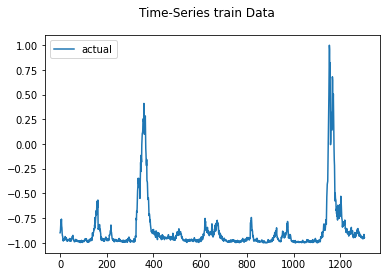

2023-03-06 14:08:38.792091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 14:08:38.792152: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 14:08:38.792193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 14:08:38.792511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 14:08:39.149776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.942
Test RMSE: 62.784
Test sMAPE: 135.642
Test R Squared: -2.628
{'mae': 48.94151046543033, 'rmse': 62.78418161410851, 'smape': 135.64222245874413, 'r2': -2.628163847199856}


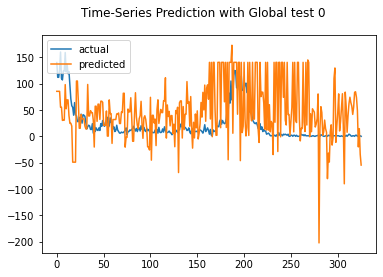

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.960
Test RMSE: 69.774
Test sMAPE: 157.306
Test R Squared: -3.481
{'mae': 53.96044711466947, 'rmse': 69.77387295248077, 'smape': 157.3055922466801, 'r2': -3.480970413977772}


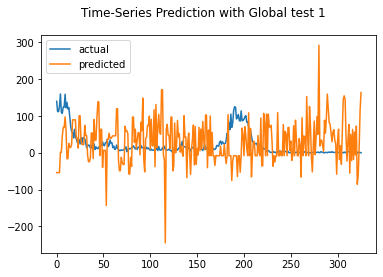

Test MAE: 60.466
Test RMSE: 69.009
Test sMAPE: 135.755
Test R Squared: -3.383
{'mae': 60.46618103615345, 'rmse': 69.00906109016663, 'smape': 135.75526554592523, 'r2': -3.3832743434229045}


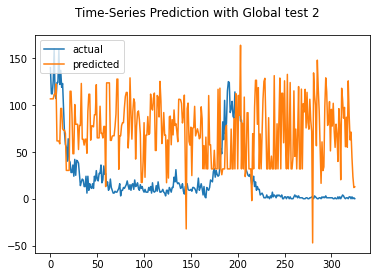

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 51.871
Test RMSE: 61.177
Test sMAPE: 138.796
Test R Squared: -2.445
{'mae': 51.870775022206864, 'rmse': 61.17693372584271, 'smape': 138.7963314692856, 'r2': -2.44478267047917}


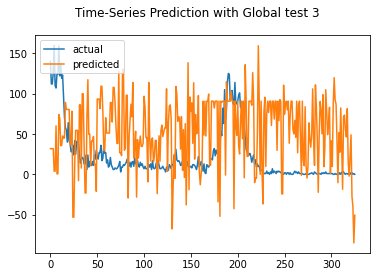

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 51.654
Test RMSE: 62.305
Test sMAPE: 134.245
Test R Squared: -2.573
{'mae': 51.65373013483966, 'rmse': 62.304773169601596, 'smape': 134.2446290401885, 'r2': -2.572967408278432}


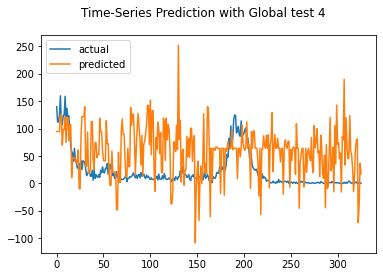

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 40.869
Test RMSE: 52.798
Test sMAPE: 128.631
Test R Squared: -1.566
{'mae': 40.8690419083724, 'rmse': 52.79811094895143, 'smape': 128.63142459957118, 'r2': -1.5658022686619706}


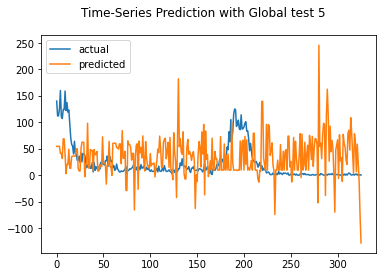

Test MAE: 53.453
Test RMSE: 68.241
Test sMAPE: 145.189
Test R Squared: -3.286
{'mae': 53.45260563181953, 'rmse': 68.24070965839127, 'smape': 145.1887921475214, 'r2': -3.286210396118464}


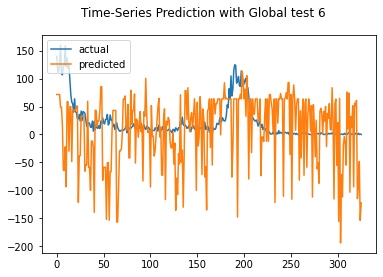

Test MAE: 69.626
Test RMSE: 100.941
Test sMAPE: 136.970
Test R Squared: -8.378
{'mae': 69.62630548515568, 'rmse': 100.94137508025509, 'smape': 136.96962332908464, 'r2': -8.378315728005665}


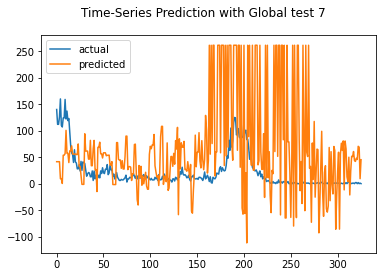

Test MAE: 108.774
Test RMSE: 125.784
Test sMAPE: 160.544
Test R Squared: -13.563
{'mae': 108.77393988414777, 'rmse': 125.78390198217112, 'smape': 160.5437718006221, 'r2': -13.56252024690251}


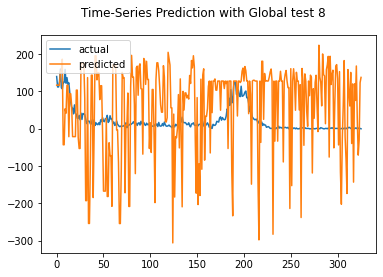

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 62.357
Test RMSE: 75.527
Test sMAPE: 136.788
Test R Squared: -4.250
{'mae': 62.356655820015746, 'rmse': 75.52720875430659, 'smape': 136.78796478383578, 'r2': -4.250410816034848}


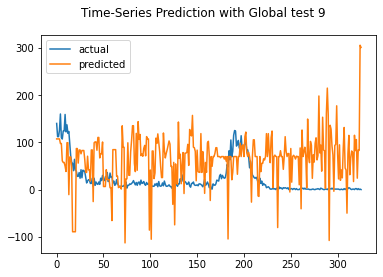

Test MAE: 72.781
Test RMSE: 86.393
Test sMAPE: 159.837
Test R Squared: -5.870
{'mae': 72.78139139757566, 'rmse': 86.39275475100594, 'smape': 159.83729823895754, 'r2': -5.869752025652156}


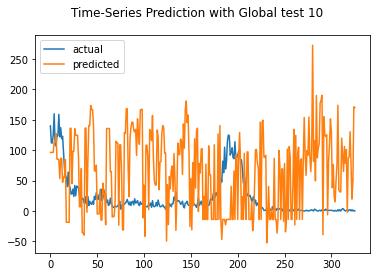

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 51.729
Test RMSE: 62.478
Test sMAPE: 133.807
Test R Squared: -2.593
{'mae': 51.7292367914703, 'rmse': 62.478452417894545, 'smape': 133.80744206184698, 'r2': -2.5929150038598023}


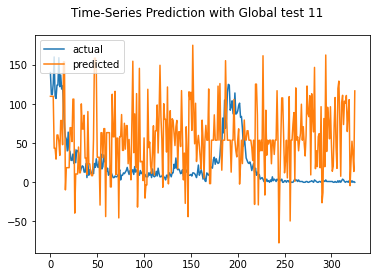

Test MAE: 69.579
Test RMSE: 99.859
Test sMAPE: 139.662
Test R Squared: -8.178
{'mae': 69.57914606852034, 'rmse': 99.85947770266027, 'smape': 139.6616744013324, 'r2': -8.178358071955625}


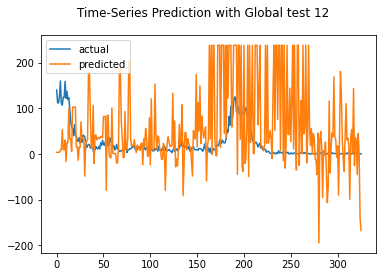

Test MAE: 53.858
Test RMSE: 60.967
Test sMAPE: 132.681
Test R Squared: -2.421
{'mae': 53.858406999359836, 'rmse': 60.96652676008775, 'smape': 132.68051724597453, 'r2': -2.421128008322244}


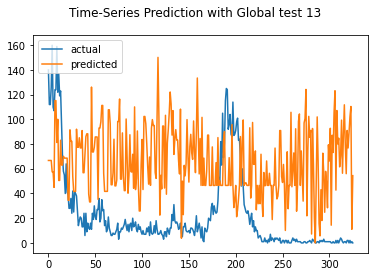

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 44.136
Test RMSE: 56.792
Test sMAPE: 140.083
Test R Squared: -1.969
{'mae': 44.13593101556316, 'rmse': 56.79173442036502, 'smape': 140.0833095055993, 'r2': -1.9686341609930187}


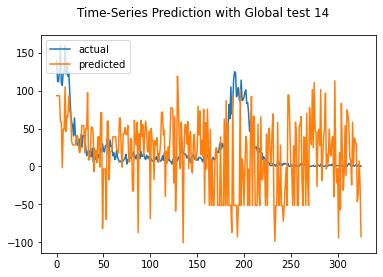

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 43.658
Test RMSE: 54.171
Test sMAPE: 135.702
Test R Squared: -1.701
{'mae': 43.657528210637025, 'rmse': 54.17054789328665, 'smape': 135.7017284588343, 'r2': -1.7009271629344034}


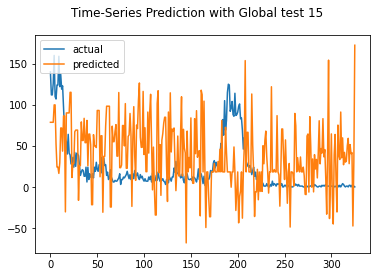

Test MAE: 75.850
Test RMSE: 91.446
Test sMAPE: 161.575
Test R Squared: -6.697
{'mae': 75.85014606034098, 'rmse': 91.44588113138427, 'smape': 161.57545482080698, 'r2': -6.696879972373906}


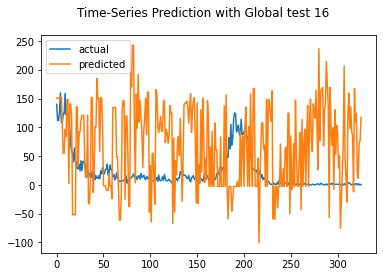

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.927
Test RMSE: 55.814
Test sMAPE: 128.248
Test R Squared: -1.867
{'mae': 47.92664224457887, 'rmse': 55.814201253459025, 'smape': 128.2479989658823, 'r2': -1.8673178889595885}


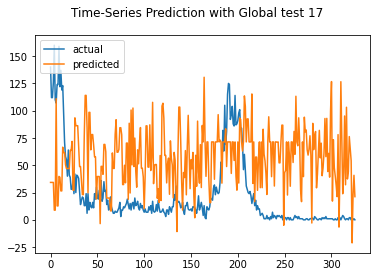

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 34.234
Test RMSE: 43.909
Test sMAPE: 121.671
Test R Squared: -0.775
{'mae': 34.233966124386875, 'rmse': 43.90937222131599, 'smape': 121.6714111014526, 'r2': -0.7746016139757712}


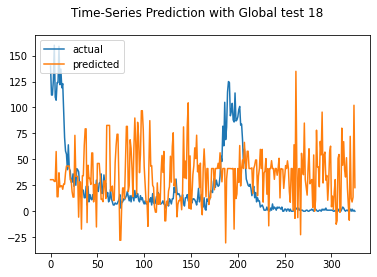

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 43.171
Test RMSE: 50.149
Test sMAPE: 128.765
Test R Squared: -1.315
{'mae': 43.17142056669194, 'rmse': 50.14902512366285, 'smape': 128.76524129887915, 'r2': -1.3147889796045331}


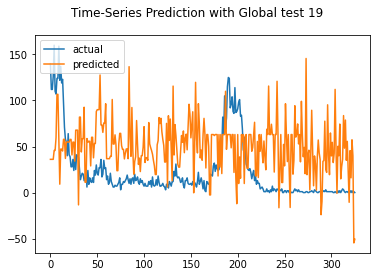

Test MAE: 89.751
Test RMSE: 109.474
Test sMAPE: 155.107
Test R Squared: -10.031
{'mae': 89.75143289200368, 'rmse': 109.47395764682443, 'smape': 155.10654611305657, 'r2': -10.030826498960856}


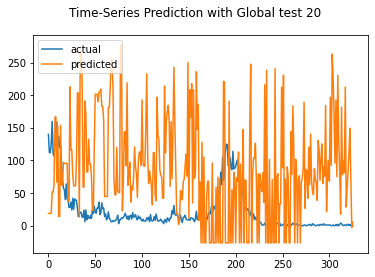

Test MAE: 52.380
Test RMSE: 60.934
Test sMAPE: 129.477
Test R Squared: -2.417
{'mae': 52.3800110844381, 'rmse': 60.93393447139478, 'smape': 129.4770486372223, 'r2': -2.417471162724558}


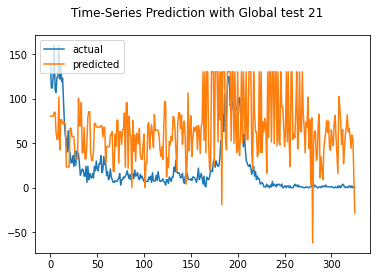

Test MAE: 70.504
Test RMSE: 116.239
Test sMAPE: 130.797
Test R Squared: -11.436
{'mae': 70.50385116214402, 'rmse': 116.23924231151874, 'smape': 130.79650687300236, 'r2': -11.436321966089352}


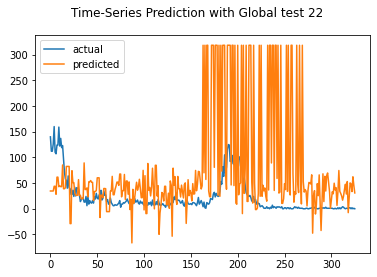

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 40.181
Test RMSE: 47.431
Test sMAPE: 130.635
Test R Squared: -1.071
{'mae': 40.18079539466124, 'rmse': 47.4307442163641, 'smape': 130.63454923699763, 'r2': -1.0706480813408397}


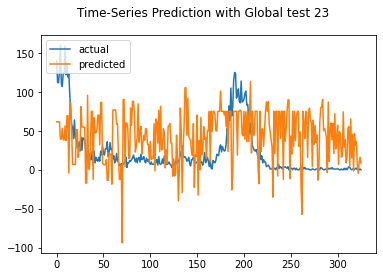

Test MAE: 36.993
Test RMSE: 46.757
Test sMAPE: 120.693
Test R Squared: -1.012
{'mae': 36.99268706919957, 'rmse': 46.757298022663335, 'smape': 120.69326121126865, 'r2': -1.0122652586057486}


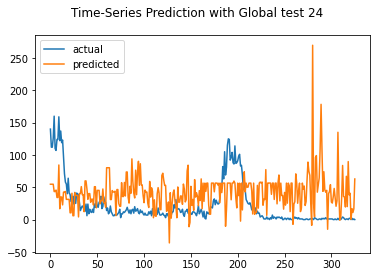

Test MAE: 108.780
Test RMSE: 122.080
Test sMAPE: 158.477
Test R Squared: -12.717
{'mae': 108.78026007582073, 'rmse': 122.07975708645637, 'smape': 158.47701760778568, 'r2': -12.717460841844373}


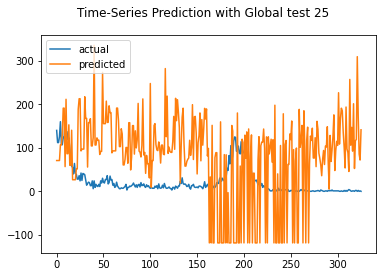

Test MAE: 103.296
Test RMSE: 122.042
Test sMAPE: 152.565
Test R Squared: -12.709
{'mae': 103.2961564049399, 'rmse': 122.0419209784561, 'smape': 152.5654162075867, 'r2': -12.708959270196019}


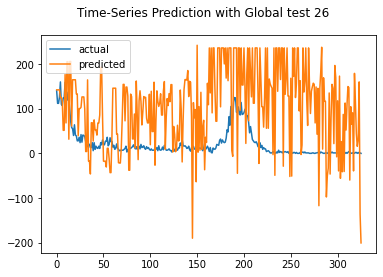

Test MAE: 46.916
Test RMSE: 65.081
Test sMAPE: 141.246
Test R Squared: -2.898
{'mae': 46.91598988996327, 'rmse': 65.08070382560523, 'smape': 141.24638197585136, 'r2': -2.898440393224237}


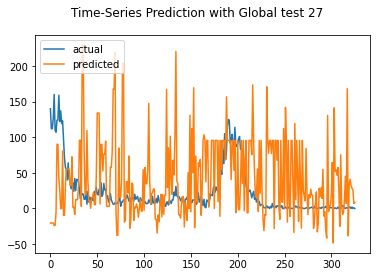

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 41.095
Test RMSE: 50.114
Test sMAPE: 131.798
Test R Squared: -1.312
{'mae': 41.094511370717385, 'rmse': 50.11394676339968, 'smape': 131.79814702312447, 'r2': -1.3115518038898122}


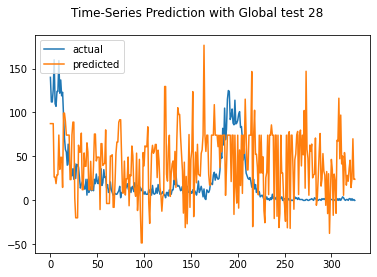

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 64.531
Test RMSE: 74.014
Test sMAPE: 138.030
Test R Squared: -4.042
{'mae': 64.53077172995344, 'rmse': 74.01352698016555, 'smape': 138.03021756459142, 'r2': -4.042067049645462}


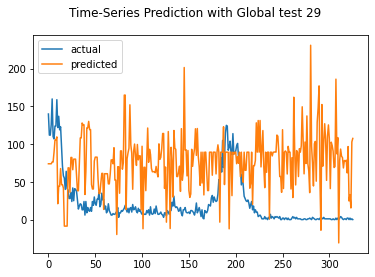

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.833
Test RMSE: 61.230
Test sMAPE: 134.603
Test R Squared: -2.451
{'mae': 50.832942973982334, 'rmse': 61.22968613109228, 'smape': 134.60309234048023, 'r2': -2.450726051701208}


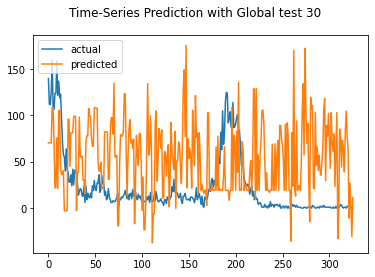

Test MAE: 73.627
Test RMSE: 98.394
Test sMAPE: 144.950
Test R Squared: -7.911
{'mae': 73.62712114446002, 'rmse': 98.39442637711309, 'smape': 144.95005260579563, 'r2': -7.911019881393877}


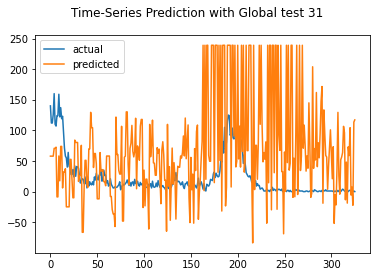

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 57.370
Test RMSE: 69.270
Test sMAPE: 141.338
Test R Squared: -3.416
{'mae': 57.3702312868797, 'rmse': 69.26979390145756, 'smape': 141.3376136559648, 'r2': -3.416459042082841}


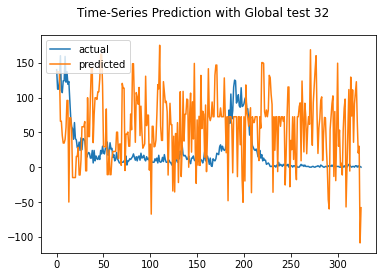

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.998
Test RMSE: 57.254
Test sMAPE: 129.893
Test R Squared: -2.017
{'mae': 49.99766403546363, 'rmse': 57.25377965337649, 'smape': 129.89314499387342, 'r2': -2.017134985020834}


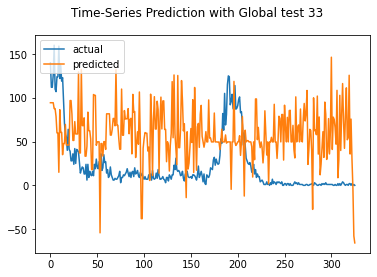

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 47.324
Test RMSE: 62.968
Test sMAPE: 134.790
Test R Squared: -2.649
{'mae': 47.32363936944973, 'rmse': 62.96775351378685, 'smape': 134.78966367835255, 'r2': -2.6494113206536456}


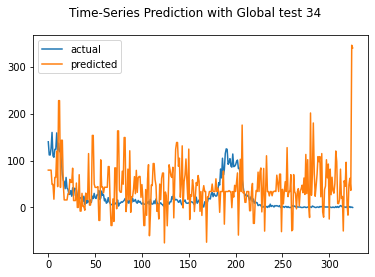

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 44.245
Test RMSE: 52.792
Test sMAPE: 130.431
Test R Squared: -1.565
{'mae': 44.24458108357857, 'rmse': 52.79150582708358, 'smape': 130.43111546186435, 'r2': -1.5651603374907967}


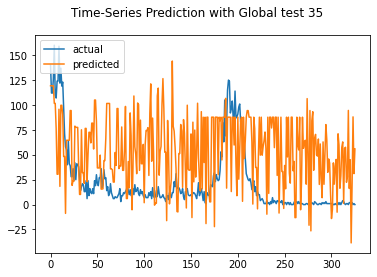

Test MAE: 61.528
Test RMSE: 74.708
Test sMAPE: 138.356
Test R Squared: -4.137
{'mae': 61.527690041833125, 'rmse': 74.70784878831745, 'smape': 138.3560275781741, 'r2': -4.137110154830584}


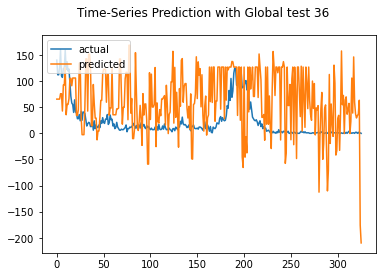

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 45.510
Test RMSE: 50.459
Test sMAPE: 129.736
Test R Squared: -1.344
{'mae': 45.510427202915125, 'rmse': 50.459198693593095, 'smape': 129.7359248745509, 'r2': -1.3435116415396715}


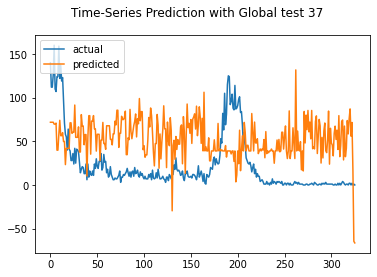

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 46.038
Test RMSE: 54.684
Test sMAPE: 129.486
Test R Squared: -1.752
{'mae': 46.037828500651145, 'rmse': 54.6839018740446, 'smape': 129.48627093132865, 'r2': -1.7523610725292942}


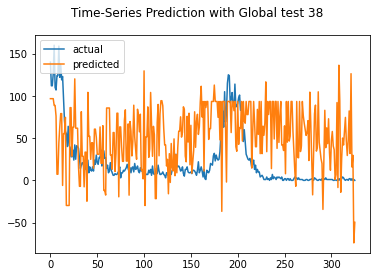

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 61.010
Test RMSE: 72.714
Test sMAPE: 137.579
Test R Squared: -3.867
{'mae': 61.0101661159217, 'rmse': 72.7138511827629, 'smape': 137.57879565233708, 'r2': -3.866544626809233}


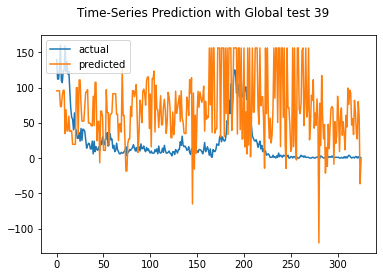

Test MAE: 47.115
Test RMSE: 60.209
Test sMAPE: 137.652
Test R Squared: -2.337
{'mae': 47.115298700753165, 'rmse': 60.209346830768126, 'smape': 137.6524835037287, 'r2': -2.3366776164591676}


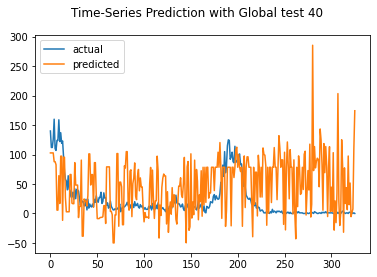

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 47.732
Test RMSE: 56.301
Test sMAPE: 134.367
Test R Squared: -1.918
{'mae': 47.732111390017295, 'rmse': 56.3011334616716, 'smape': 134.36662532338, 'r2': -1.9175660226657074}


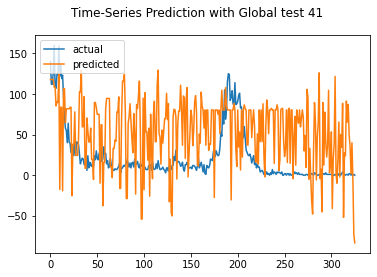

Test MAE: 73.227
Test RMSE: 92.230
Test sMAPE: 154.391
Test R Squared: -6.830
{'mae': 73.22739328343444, 'rmse': 92.23044165797502, 'smape': 154.39131214029084, 'r2': -6.8295173864507355}


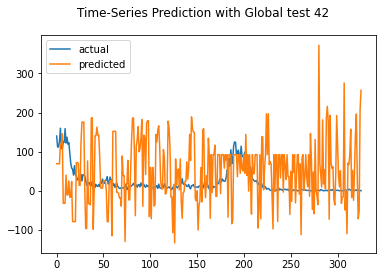

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 49.790
Test RMSE: 60.545
Test sMAPE: 134.075
Test R Squared: -2.374
{'mae': 49.790190418073735, 'rmse': 60.54529323470693, 'smape': 134.07496916497985, 'r2': -2.374016406503036}


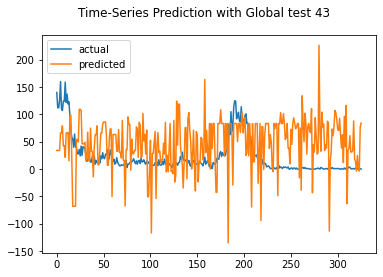

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 61.736
Test RMSE: 70.401
Test sMAPE: 136.515
Test R Squared: -3.562
{'mae': 61.735913244676006, 'rmse': 70.4013276773254, 'smape': 136.51465612882828, 'r2': -3.5619247278997577}


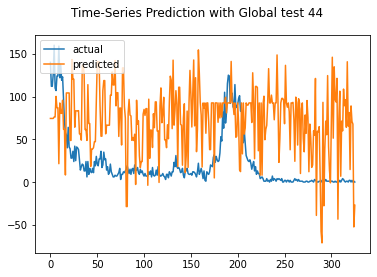

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 40.147
Test RMSE: 51.237
Test sMAPE: 134.247
Test R Squared: -1.416
{'mae': 40.14700786394576, 'rmse': 51.237238964435285, 'smape': 134.24687833004623, 'r2': -1.4163389454927757}


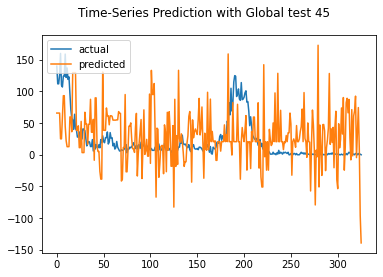

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 43.598
Test RMSE: 55.267
Test sMAPE: 150.147
Test R Squared: -1.811
{'mae': 43.59801197125137, 'rmse': 55.26694399873749, 'smape': 150.147040720731, 'r2': -1.8113655440106684}


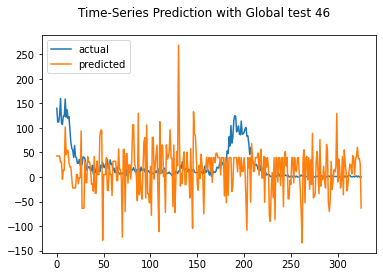

Test MAE: 65.320
Test RMSE: 72.098
Test sMAPE: 137.587
Test R Squared: -3.784
{'mae': 65.32013253054005, 'rmse': 72.09756976650128, 'smape': 137.58662947566273, 'r2': -3.7844020536587397}


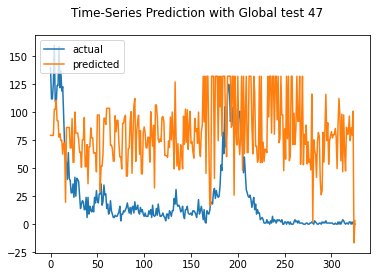

Test MAE: 49.961
Test RMSE: 59.282
Test sMAPE: 145.566
Test R Squared: -2.235
{'mae': 49.96121790218938, 'rmse': 59.281743912538744, 'smape': 145.5662594806338, 'r2': -2.234657915084586}


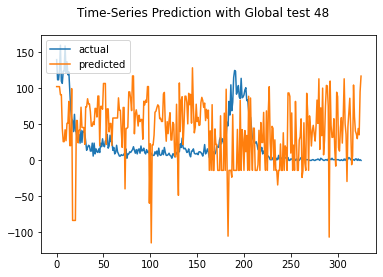

Test MAE: 75.528
Test RMSE: 86.905
Test sMAPE: 142.767
Test R Squared: -5.952
{'mae': 75.52764779119038, 'rmse': 86.9054768320974, 'smape': 142.76704908164058, 'r2': -5.9515349373436806}


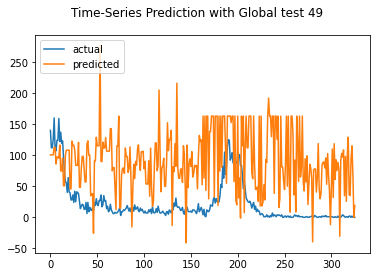

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 68.740
Test RMSE: 81.659
Test sMAPE: 140.743
Test R Squared: -5.138
{'mae': 68.74002244099518, 'rmse': 81.6593576361586, 'smape': 140.74276379444498, 'r2': -5.1375965178674265}


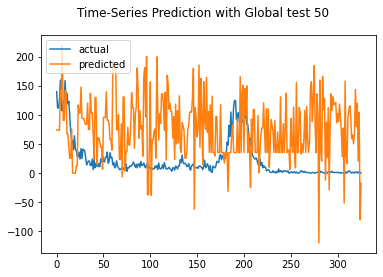

Test MAE: 90.537
Test RMSE: 109.284
Test sMAPE: 149.856
Test R Squared: -9.993
{'mae': 90.53739176681437, 'rmse': 109.2839747558974, 'smape': 149.8556271787511, 'r2': -9.992573567868911}


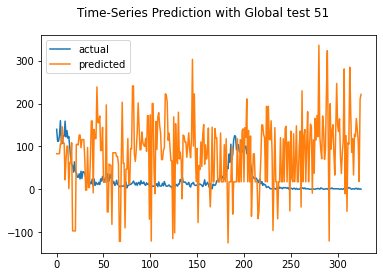

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 52.532
Test RMSE: 57.881
Test sMAPE: 133.172
Test R Squared: -2.084
{'mae': 52.53243776918189, 'rmse': 57.88109104355689, 'smape': 133.17187116582048, 'r2': -2.0836127587464732}


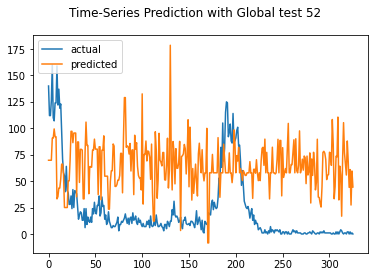

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 55.763
Test RMSE: 66.045
Test sMAPE: 135.099
Test R Squared: -3.015
{'mae': 55.76259113820784, 'rmse': 66.04523238665517, 'smape': 135.09925683253854, 'r2': -3.014850345300003}


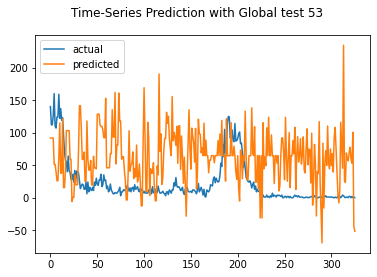

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 44.516
Test RMSE: 56.405
Test sMAPE: 140.880
Test R Squared: -1.928
{'mae': 44.51557578064181, 'rmse': 56.405223854965854, 'smape': 140.88014482931627, 'r2': -1.928364076273894}


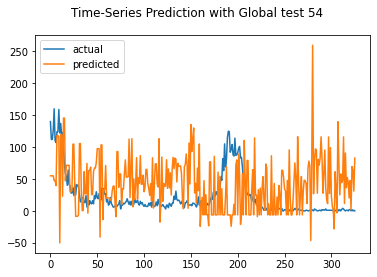

Test MAE: 43.833
Test RMSE: 60.178
Test sMAPE: 132.960
Test R Squared: -2.333
{'mae': 43.832842443618304, 'rmse': 60.17768361566445, 'smape': 132.9596767222318, 'r2': -2.333169119297793}


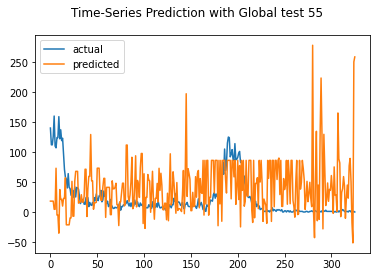

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.078
Test RMSE: 54.462
Test sMAPE: 129.767
Test R Squared: -1.730
{'mae': 45.07757705651178, 'rmse': 54.4623451768962, 'smape': 129.76674186385185, 'r2': -1.7301033816888083}


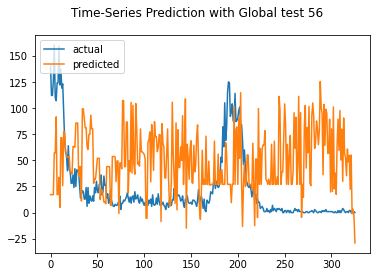

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 51.105
Test RMSE: 57.655
Test sMAPE: 132.992
Test R Squared: -2.060
{'mae': 51.10478154355032, 'rmse': 57.6548571161663, 'smape': 132.99222354245057, 'r2': -2.0595546610662887}


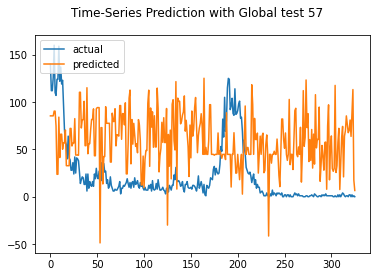

Test MAE: 61.071
Test RMSE: 69.687
Test sMAPE: 136.416
Test R Squared: -3.470
{'mae': 61.07064582672587, 'rmse': 69.68685812952197, 'smape': 136.41640596725338, 'r2': -3.469800968959328}


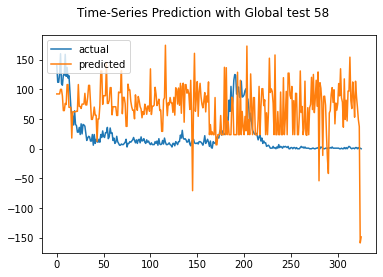

Test MAE: 52.412
Test RMSE: 62.848
Test sMAPE: 131.547
Test R Squared: -2.636
{'mae': 52.4117103156868, 'rmse': 62.8478113307328, 'smape': 131.54695271643013, 'r2': -2.635521624766476}


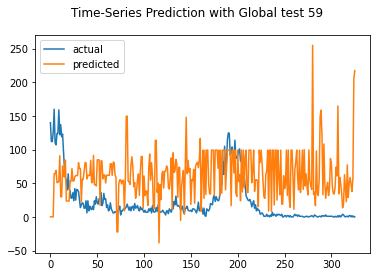

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 41.884
Test RMSE: 53.033
Test sMAPE: 135.357
Test R Squared: -1.589
{'mae': 41.88377558645661, 'rmse': 53.03292750917129, 'smape': 135.35698535086138, 'r2': -1.5886755354606361}


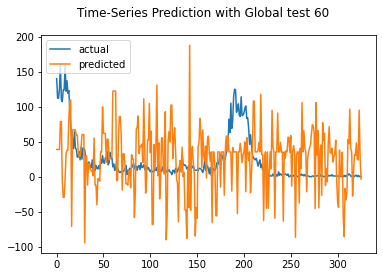

Test MAE: 122.036
Test RMSE: 143.277
Test sMAPE: 158.789
Test R Squared: -17.895
{'mae': 122.03567308370322, 'rmse': 143.2766463043214, 'smape': 158.78862827151576, 'r2': -17.8945794932082}


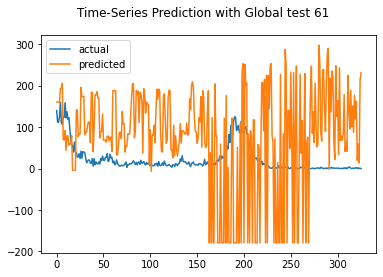

Test MAE: 78.611
Test RMSE: 92.788
Test sMAPE: 141.989
Test R Squared: -6.924
{'mae': 78.61140504497692, 'rmse': 92.78785334082211, 'smape': 141.98937335445774, 'r2': -6.924441632765251}


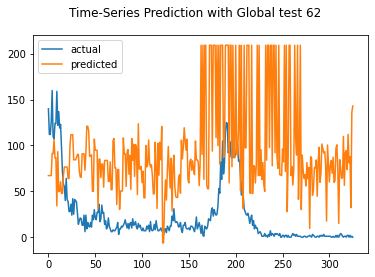

Test MAE: 70.513
Test RMSE: 89.837
Test sMAPE: 141.595
Test R Squared: -6.428
{'mae': 70.51307923589016, 'rmse': 89.83678480334531, 'smape': 141.59488039182904, 'r2': -6.428392059245616}


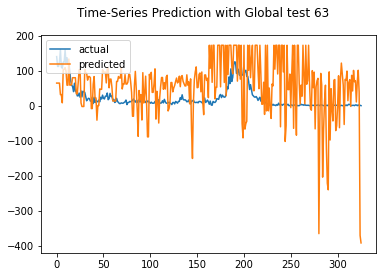

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 49.469
Test RMSE: 56.897
Test sMAPE: 132.382
Test R Squared: -1.980
{'mae': 49.46918933523213, 'rmse': 56.89653184294089, 'smape': 132.38237598115225, 'r2': -1.97960027259507}


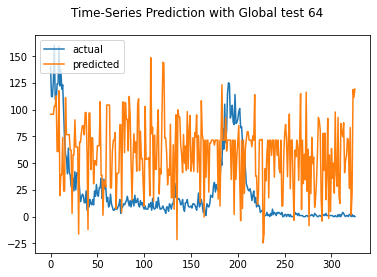

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 45.934
Test RMSE: 52.105
Test sMAPE: 127.022
Test R Squared: -1.499
{'mae': 45.933772925218925, 'rmse': 52.10478557554652, 'smape': 127.02194084778363, 'r2': -1.4988583716616546}


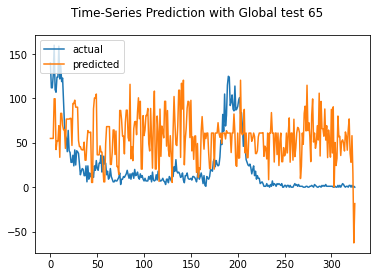

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.651
Test RMSE: 54.298
Test sMAPE: 129.225
Test R Squared: -1.714
{'mae': 43.650826415766964, 'rmse': 54.29848621853472, 'smape': 129.22536604532593, 'r2': -1.7137001611198777}


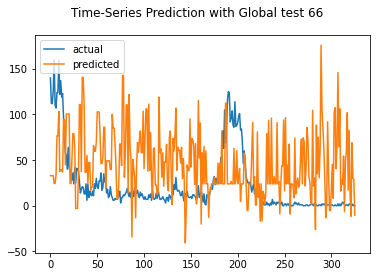

Test MAE: 74.912
Test RMSE: 101.405
Test sMAPE: 150.572
Test R Squared: -8.465
{'mae': 74.91249525876133, 'rmse': 101.40461473948825, 'smape': 150.5719959153076, 'r2': -8.46459108230736}


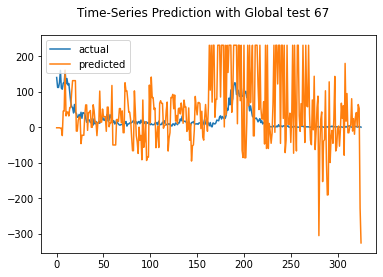

Test MAE: 58.353
Test RMSE: 73.102
Test sMAPE: 136.924
Test R Squared: -3.919
{'mae': 58.35258044951532, 'rmse': 73.10190526543332, 'smape': 136.92384997086543, 'r2': -3.9186260841755907}


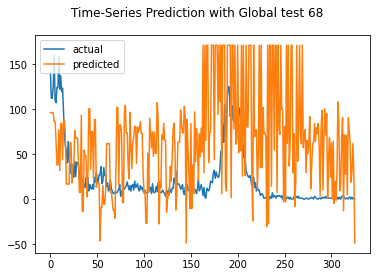

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 32.008
Test RMSE: 43.386
Test sMAPE: 126.659
Test R Squared: -0.733
{'mae': 32.00785519795184, 'rmse': 43.386218210471974, 'smape': 126.65877878002834, 'r2': -0.7325668820394069}


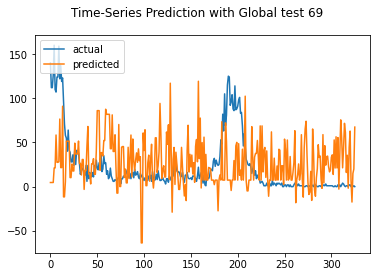

Test MAE: 113.387
Test RMSE: 133.119
Test sMAPE: 166.526
Test R Squared: -15.310
{'mae': 113.38665018911742, 'rmse': 133.1185510997363, 'smape': 166.52648649400572, 'r2': -15.310361252661636}


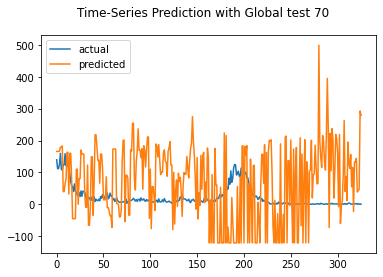

Test MAE: 60.431
Test RMSE: 72.014
Test sMAPE: 135.110
Test R Squared: -3.773
{'mae': 60.43098207046649, 'rmse': 72.01438636597729, 'smape': 135.110316850533, 'r2': -3.7733683046724726}


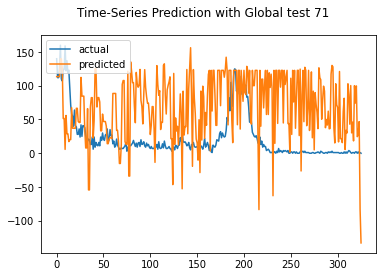

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 50.359
Test RMSE: 63.320
Test sMAPE: 148.732
Test R Squared: -2.690
{'mae': 50.3594362291456, 'rmse': 63.32034386128952, 'smape': 148.73168217444137, 'r2': -2.690395784251437}


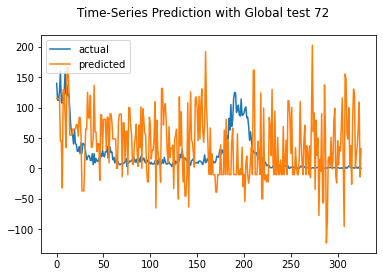

Test MAE: 59.831
Test RMSE: 80.473
Test sMAPE: 148.438
Test R Squared: -4.961
{'mae': 59.83098464747148, 'rmse': 80.4727254909591, 'smape': 148.43751361193583, 'r2': -4.960515712755392}


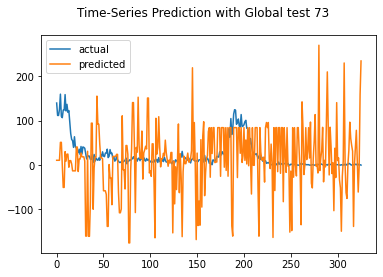

Test MAE: 58.724
Test RMSE: 68.200
Test sMAPE: 149.912
Test R Squared: -3.281
{'mae': 58.72353259350624, 'rmse': 68.20018496515614, 'smape': 149.9115342535077, 'r2': -3.2811211821495423}


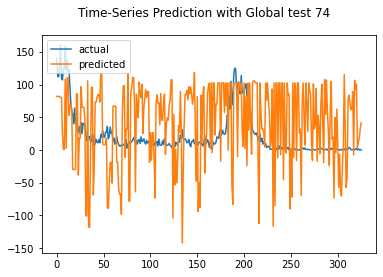

Test MAE: 65.859
Test RMSE: 83.222
Test sMAPE: 137.650
Test R Squared: -5.375
{'mae': 65.8593043421675, 'rmse': 83.22211266660585, 'smape': 137.64979109729248, 'r2': -5.374760740002257}


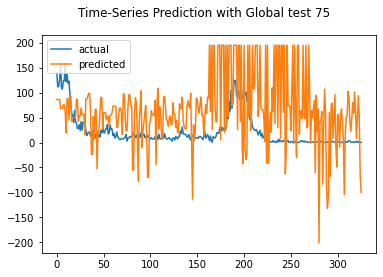

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 49.851
Test RMSE: 62.676
Test sMAPE: 127.561
Test R Squared: -2.616
{'mae': 49.850994309033354, 'rmse': 62.67582341098474, 'smape': 127.56120306623197, 'r2': -2.6156510757690397}


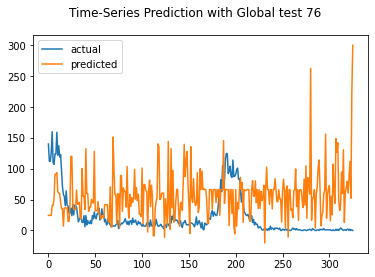

Test MAE: 55.631
Test RMSE: 62.799
Test sMAPE: 133.350
Test R Squared: -2.630
{'mae': 55.63097914230604, 'rmse': 62.798965622880935, 'smape': 133.35048013813977, 'r2': -2.629872720996515}


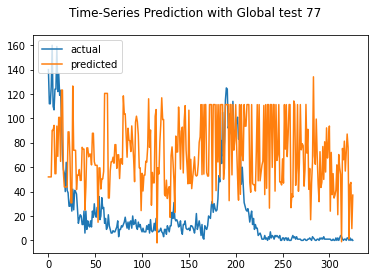

Test MAE: 94.310
Test RMSE: 105.605
Test sMAPE: 157.079
Test R Squared: -9.265
{'mae': 94.31001868569778, 'rmse': 105.60470978980473, 'smape': 157.07851128059204, 'r2': -9.26485906758751}


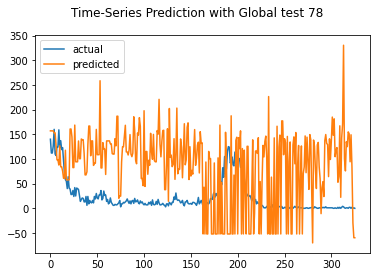

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 47.086
Test RMSE: 58.989
Test sMAPE: 127.287
Test R Squared: -2.203
{'mae': 47.08632132173316, 'rmse': 58.98924887014622, 'smape': 127.28670105465105, 'r2': -2.202817173944396}


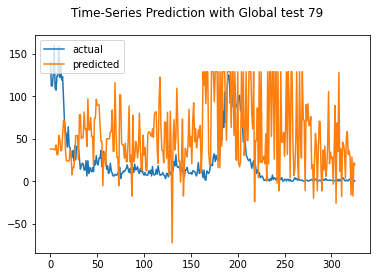

Test MAE: 82.997
Test RMSE: 117.015
Test sMAPE: 140.790
Test R Squared: -11.603
{'mae': 82.99695837570846, 'rmse': 117.01505478378003, 'smape': 140.78950127113276, 'r2': -11.602882777032033}


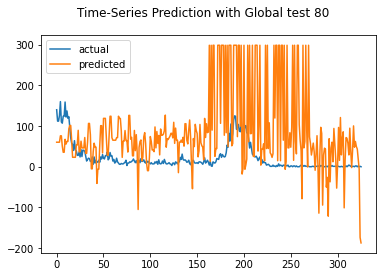

Test MAE: 68.729
Test RMSE: 88.141
Test sMAPE: 137.163
Test R Squared: -6.151
{'mae': 68.72940855157887, 'rmse': 88.14066943354128, 'smape': 137.1632656061125, 'r2': -6.150544365534031}


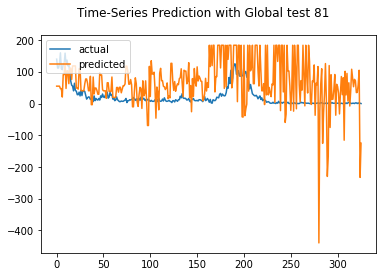

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 32.179
Test RMSE: 42.187
Test sMAPE: 122.622
Test R Squared: -0.638
{'mae': 32.17868012555538, 'rmse': 42.18720131277416, 'smape': 122.62185420170961, 'r2': -0.6381280501554965}


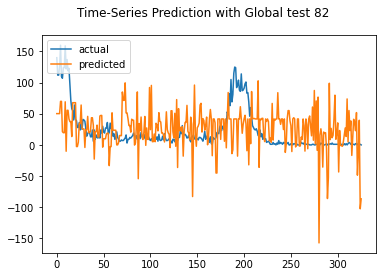

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 43.888
Test RMSE: 51.837
Test sMAPE: 129.705
Test R Squared: -1.473
{'mae': 43.888118589216944, 'rmse': 51.83673923653267, 'smape': 129.7051362028322, 'r2': -1.4732143945965288}


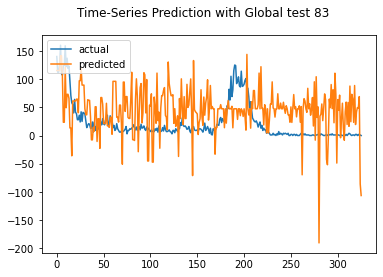

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 51.651
Test RMSE: 64.624
Test sMAPE: 141.107
Test R Squared: -2.844
{'mae': 51.6513733463419, 'rmse': 64.62383645865947, 'smape': 141.10681923075828, 'r2': -2.843898308531801}


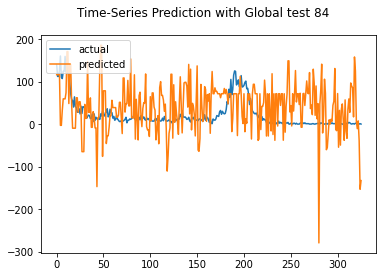

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 44.729
Test RMSE: 53.817
Test sMAPE: 135.240
Test R Squared: -1.666
{'mae': 44.72936815334244, 'rmse': 53.81735223499993, 'smape': 135.24025274586063, 'r2': -1.6658215250524244}


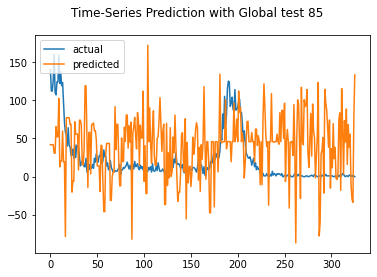

Test MAE: 67.282
Test RMSE: 102.892
Test sMAPE: 142.887
Test R Squared: -8.744
{'mae': 67.2824606303057, 'rmse': 102.89182954369993, 'smape': 142.8865355324746, 'r2': -8.744245010476844}


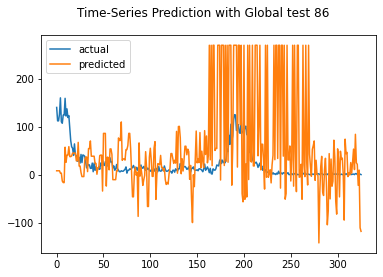

Test MAE: 67.945
Test RMSE: 81.894
Test sMAPE: 136.204
Test R Squared: -5.173
{'mae': 67.94541998801787, 'rmse': 81.89393961317842, 'smape': 136.20420307092823, 'r2': -5.172909985237932}


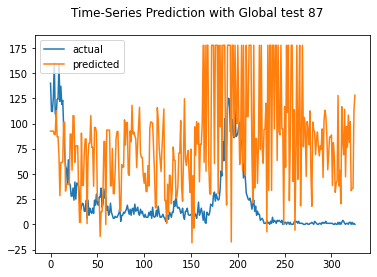

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 50.904
Test RMSE: 59.061
Test sMAPE: 131.792
Test R Squared: -2.211
{'mae': 50.903999743286086, 'rmse': 59.06092808326587, 'smape': 131.7918825127112, 'r2': -2.2106055387877093}


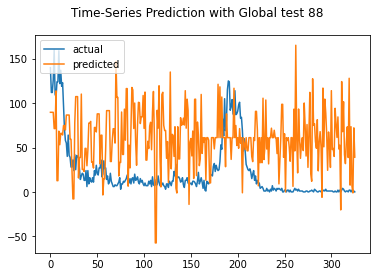

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 43.786
Test RMSE: 53.693
Test sMAPE: 127.915
Test R Squared: -1.653
{'mae': 43.785782968339745, 'rmse': 53.69254712630071, 'smape': 127.91456145331203, 'r2': -1.6534715171809222}


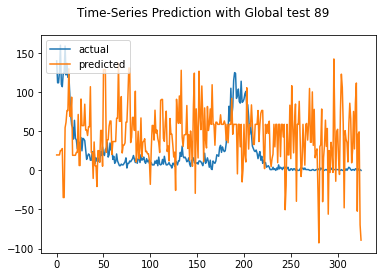

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 49.331
Test RMSE: 62.968
Test sMAPE: 142.303
Test R Squared: -2.649
{'mae': 49.33053434224217, 'rmse': 62.96837075620781, 'smape': 142.30285572010015, 'r2': -2.649482867831157}


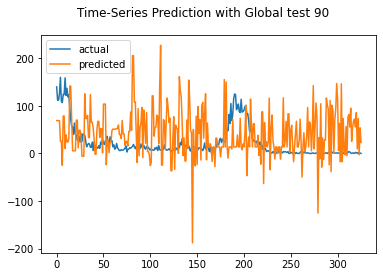

Test MAE: 88.270
Test RMSE: 106.102
Test sMAPE: 162.437
Test R Squared: -9.362
{'mae': 88.26997117250244, 'rmse': 106.10203759733668, 'smape': 162.43661600757693, 'r2': -9.36176801111001}


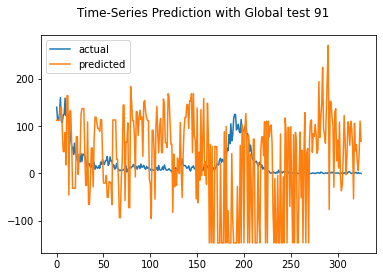

Test MAE: 57.616
Test RMSE: 72.088
Test sMAPE: 147.827
Test R Squared: -3.783
{'mae': 57.61596460357034, 'rmse': 72.08795530307847, 'smape': 147.8266556930677, 'r2': -3.7831261052016867}


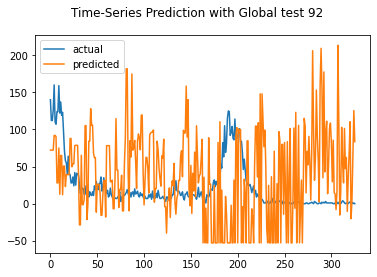

Test MAE: 69.968
Test RMSE: 99.155
Test sMAPE: 148.870
Test R Squared: -8.049
{'mae': 69.96773777691864, 'rmse': 99.15490880654414, 'smape': 148.86975305138168, 'r2': -8.049297271217505}


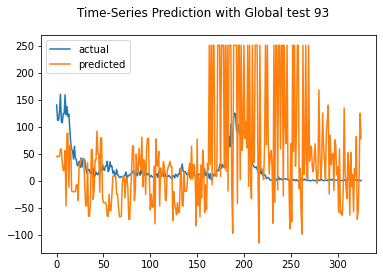

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 55.098
Test RMSE: 64.373
Test sMAPE: 133.704
Test R Squared: -2.814
{'mae': 55.09837546158422, 'rmse': 64.37268037273236, 'smape': 133.70363721449553, 'r2': -2.8140782764651098}


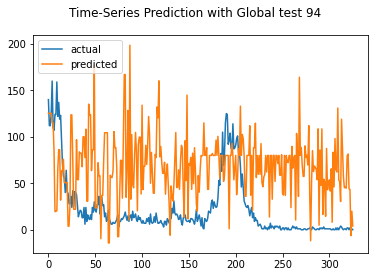

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 51.612
Test RMSE: 60.968
Test sMAPE: 132.270
Test R Squared: -2.421
{'mae': 51.611596813505415, 'rmse': 60.967867696004326, 'smape': 132.26961611408723, 'r2': -2.4212785028350754}


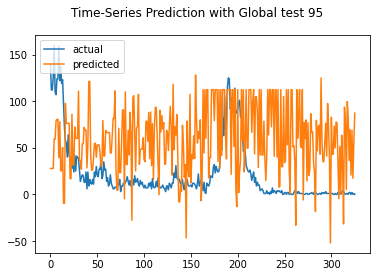

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 42.276
Test RMSE: 50.765
Test sMAPE: 126.859
Test R Squared: -1.372
{'mae': 42.27637666390717, 'rmse': 50.764600479741766, 'smape': 126.85945526959684, 'r2': -1.3719654643241812}


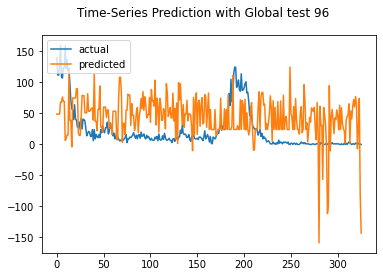

Test MAE: 66.501
Test RMSE: 80.166
Test sMAPE: 135.530
Test R Squared: -4.915
{'mae': 66.50144653525089, 'rmse': 80.16587800886639, 'smape': 135.53016721486927, 'r2': -4.9151467448012705}


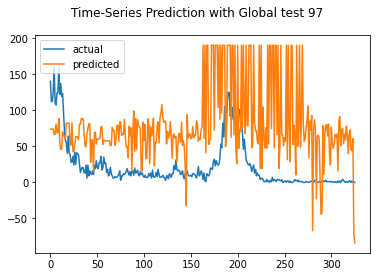

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 46.203
Test RMSE: 54.745
Test sMAPE: 131.041
Test R Squared: -1.759
{'mae': 46.20254916162944, 'rmse': 54.74532121914562, 'smape': 131.04063821842846, 'r2': -1.7585472861586453}


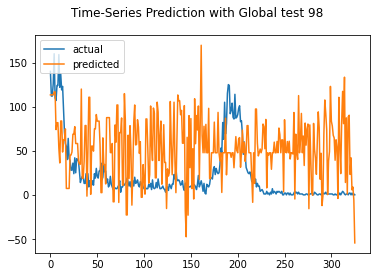

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 51.722
Test RMSE: 59.182
Test sMAPE: 134.425
Test R Squared: -2.224
{'mae': 51.721644573599285, 'rmse': 59.182392119327, 'smape': 134.424606969097, 'r2': -2.2238249082337633}


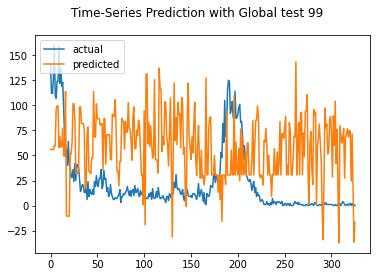

rmse : average=71.958, std=21.980
mae : average=58.561, std=17.760
smape : average=138.555, std=9.797
r2 : average=-4.210, std=3.475


([71.95751748419181, 21.97967200358796],
 [58.5607189162944, 17.7599099987602],
 [138.55476463938237, 9.796972225793057],
 [-4.210493125458232, 3.4752377492790516])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
